In [1]:
import numpy as np
import h5py
import os
import time
import configparser

import torch
from torch.utils.data import DataLoader

from training_fns import create_synth_batch, batch_to_cuda, PayneObservedDataset
from network import SN_AE
from analysis import (plot_compare_estimates_resid_obs, plot_progress_obs, 
                      plot_spec_resid_density, plot_J_diff)

# Check for GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('Using GPU!')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.cuda.manual_seed(1)
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [2]:
model_name = 'ae_1'

# Directories

cur_dir = ''
config_dir = os.path.join(cur_dir, 'configs/')
model_dir = os.path.join(cur_dir, 'models/')
progress_dir = os.path.join(cur_dir, 'progress/')
data_dir = os.path.join(cur_dir, 'data/')

# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']
print('\nCreating model: %s'%model_name)
print('\nConfiguration:')
for key_head in config.keys():
    if key_head=='DEFAULT':
        continue
    print('  %s' % key_head)
    for key in config[key_head].keys():
        print('    %s: %s'%(key, config[key_head][key]))
        
# DATA FILES
data_file_obs = os.path.join(data_dir, config['DATA']['data_file_obs'])
spectra_norm_file = os.path.join(data_dir, config['DATA']['spectra_norm_file'])
emulator_fn = os.path.join(model_dir, config['DATA']['emulator_fn'])


Creating model: ae_1

Configuration:
  DATA
    spectra_norm_file: mean_and_std_PAYNE_specs.npy
    data_file_obs: aspcapStar_dr14.h5
    emulator_fn: PAYNE.pth.tar
  TRAINING
    batchsize: 4
    learning_rate_encoder: 0.0001
    learning_rate_decoder: 0.0001
    loss_weight_x: 1
    loss_weight_y: 1
    loss_weight_j: 1
    total_synth_batch_iters: 100e3
    total_obs_batch_iters: 100e3
    lr_decay_batch_iters: [5e3, 10e3, 30e3, 40e3, 80e3, 120e3, 160e3]
    lr_decay: 0.7
  ARCHITECTURE
    num_pixels: 7167
    activation: relu
    conv_filts: [32, 64, 128, 256, 512]
    conv_filt_lens: [7, 7, 7, 7, 7]
    conv_strides: [4, 4, 4, 4, 4]
    num_y: 25
    num_z: 4
  Notes
    comment: Original architecture.


In [3]:
# BUILD THE NETWORKS

# Construct the Auto-encoder
print('\nBuilding networks...')
obs_ae = SN_AE(architecture_config, emulator_fn, use_cuda=use_cuda)

# Display model architectures
print('\n\EMULATOR ARCHITECTURE:\n')
print(obs_ae.emulator)
print('\n\nENCODER ARCHITECTURE:\n')
print(obs_ae.encoder)
print('\n\nDECODER ARCHITECTURE:\n')
print(obs_ae.decoder)

# Check for pre-trained weights
model_filename =  os.path.join(model_dir,model_name+'_obs.pth.tar')
    
# Load pretrained model
print('\nLoading saved model to evaluate...')
# Load model info
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
losses = dict(checkpoint['losses'])

# Load model weights
obs_ae.load_state_dict(checkpoint['obs_ae'])


Building networks...

\EMULATOR ARCHITECTURE:

Sequential(
  (0): Linear(in_features=25, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=300, out_features=7214, bias=True)
)


ENCODER ARCHITECTURE:

Encoder(
  (conv_layers): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(4,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(7,), stride=(4,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(7,), stride=(4,))
    (5): ReLU()
    (6): Conv1d(128, 256, kernel_size=(7,), stride=(4,))
    (7): ReLU()
    (8): Conv1d(256, 512, kernel_size=(7,), stride=(4,))
    (9): ReLU()
  )
  (fc_y): Linear(in_features=3072, out_features=25, bias=True)
  (fc_z): Linear(in_features=3072, out_features=4, bias=True)
)


DECODER ARCHITECTURE:

Decoder(
  (fc_in): Linear(in_features=29, out_features=3072, bias=True)
  (conv_layers): Sequential(
    (0): ConvTranspose1d(512, 512, kernel_si

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

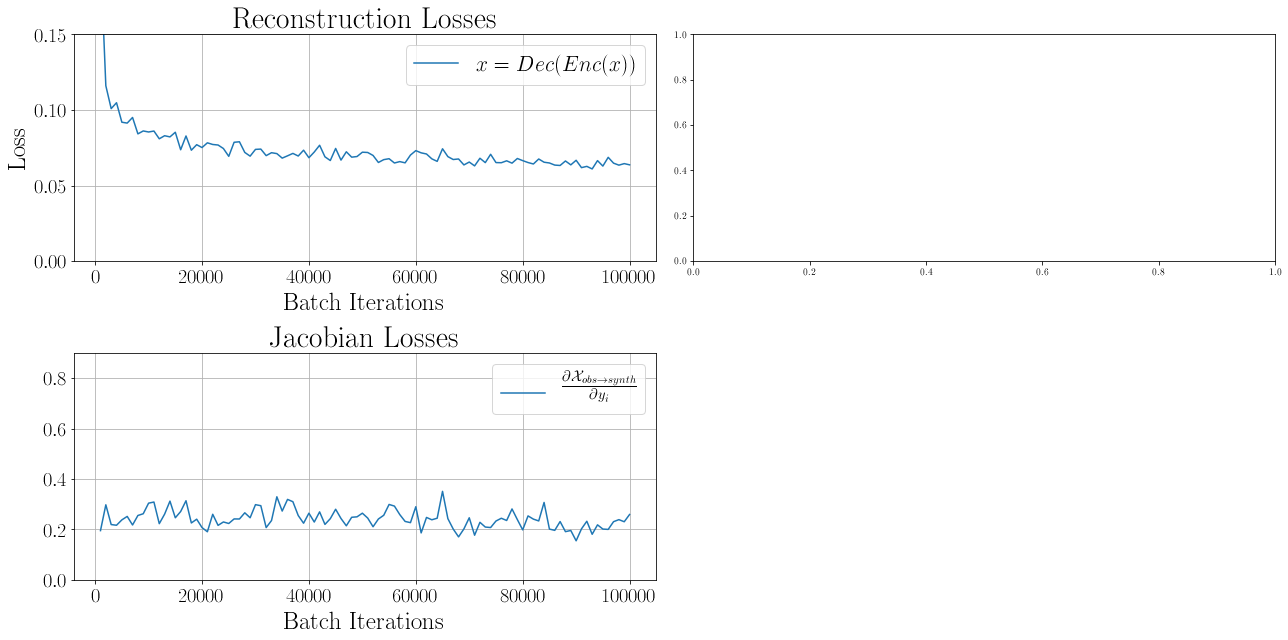

In [4]:
plot_progress_obs(losses, y_lims=[(0,0.15),(0,0.01),(0,0.9)])

In [5]:
# Normalization data for the spectra
x_mean, x_std = np.load(spectra_norm_file)

In [6]:
# Observed spectra dataset
obs_dataset = PayneObservedDataset(data_file_obs, obs_domain='APOGEE', dataset='train', 
                                   x_mean=x_mean, x_std=x_std, collect_x_mask=True)

# Collect the cluster spectra from the dataset to use as the validation set
obs_val_set = obs_dataset.__getitem__(1000, dataset='cluster', return_labels=True, collect_preceeding=True) 

# Collect SNR for cluster spectra for plotting
with h5py.File(data_file_obs, "r") as F_obs: 
    obs_val_snr = F_obs['APOGEE combined_snr cluster'][:,0]

In [7]:
# Use the encoder to predict the stellar labels
y_pred, z_pred = obs_ae.x_to_yz(obs_val_set['x'])
# Denormalize labels
y_pred = (y_pred + 0.5) * (obs_ae.y_max-obs_ae.y_min) + obs_ae.y_min

/home/obriaint/torchmed/lib/python3.6/site-packages/seaborn/distributions.py:196: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(0, a.mean())
/home/obriaint/torchmed/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


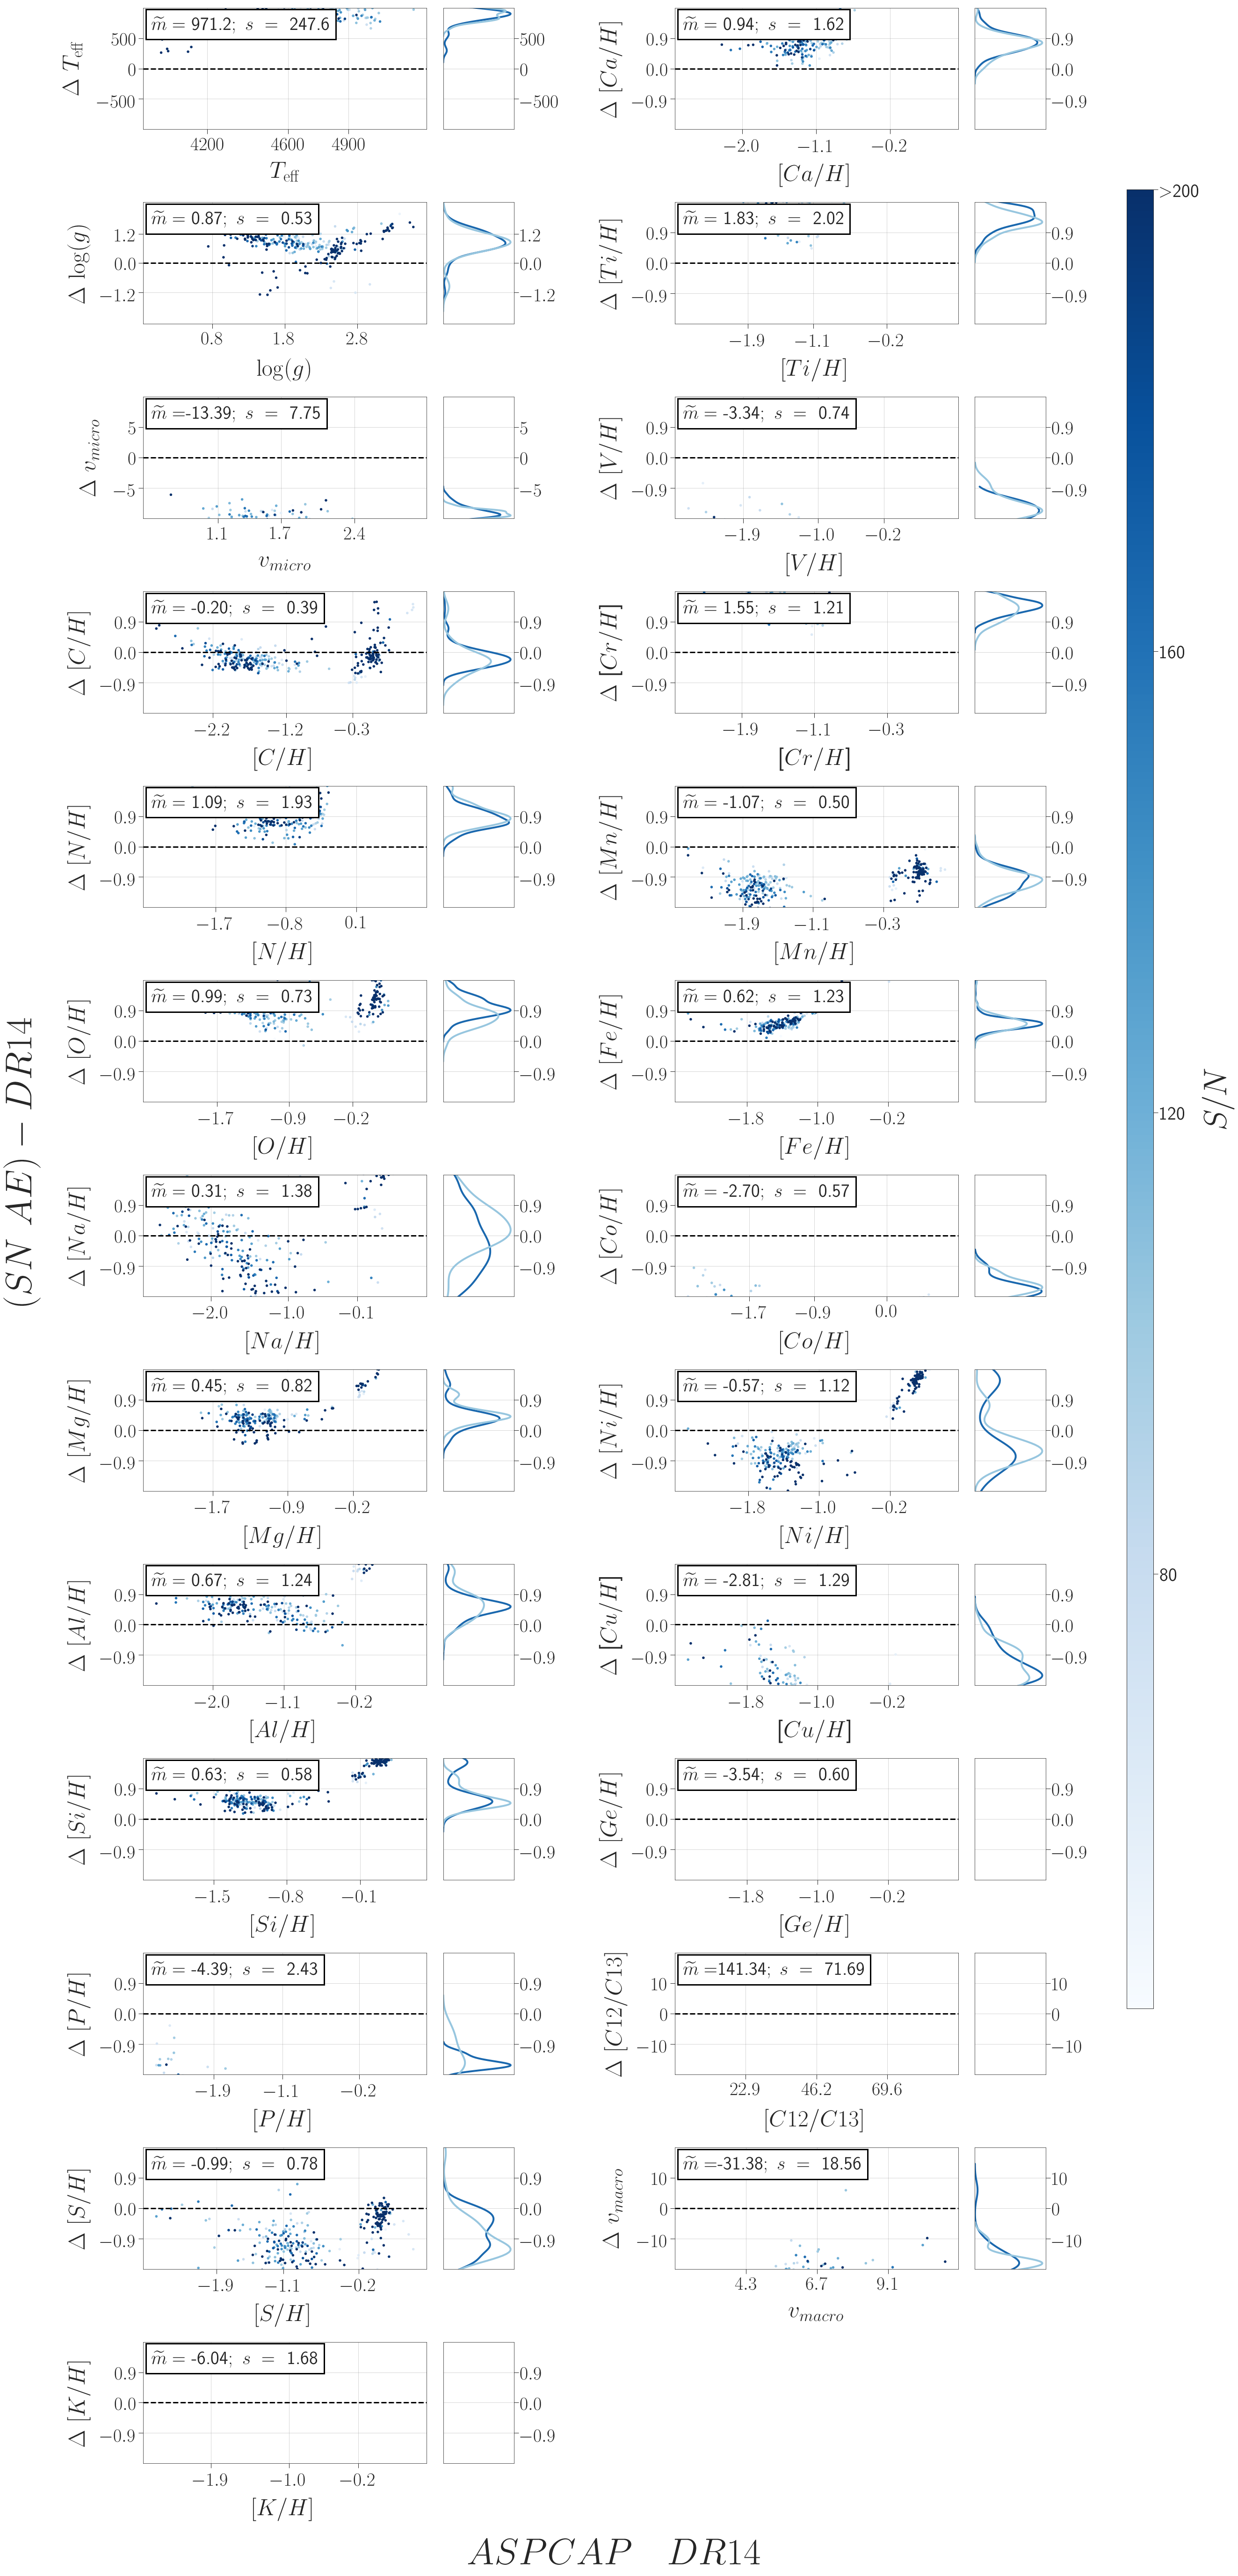

In [30]:
# Plot a comparison of the predicted stellar labels to the ground truth
resid_lims = [1000., 2.5, 10., *np.repeat(1.8, 20), 20., 20.]
resid_lims = [[-r,r] for r in resid_lims]

plot_compare_estimates_resid_obs(obs_val_set['y'].data.numpy(),  y_pred.data.numpy(), 
                                 obs_val_snr,
                                 x_lab=r'$ASPCAP \ \ \ DR14$',
                                 y_lab=r'$(SN\ AE) - DR14$', 
                                 snr_max=200, cmap='Blues', snr_cutoff=100,
                                 resid_lims = resid_lims)#,
                                #savename='figures/resids_'+model_name+'.pdf')

In [8]:
# Predict the stellar spectra from the labels
x_pred = obs_ae.yz_to_xobs(obs_val_set['y'], z_pred, raw_labels=True)
# Denormalize spectra
x_pred = x_pred.data.numpy() * x_std + x_mean
x_tgt = obs_val_set['x'].data.numpy() * x_std + x_mean

resid = [x_pred-x_tgt]

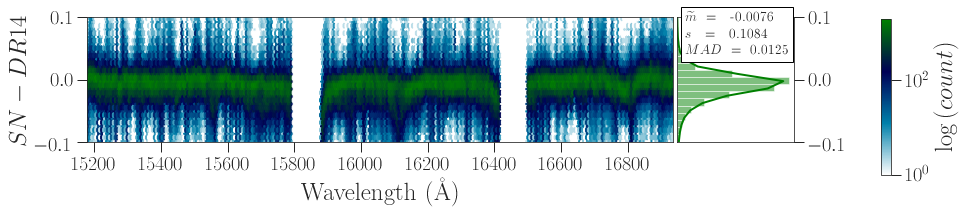

In [9]:
# Load ASPCAP wave-grid
wave_grid = np.load(data_dir+'wave_grid_ASPCAP.npy')
start_w = len(wave_grid)-x_pred.shape[1]
wave_grid = wave_grid[start_w:]

# Plot residual
plot_spec_resid_density(wave_grid, resid, labels=[r'$SN - DR14$'], ylim=(-0.1,0.1), hist=True, kde=True,
                            dist_bins=180, hex_grid=300, bias='med',
                            bias_label='$\widetilde{{m}}$ \ ',
                            cmap="ocean_r", savename=None)

In [10]:
# Reconstruct spectra using Autoencoder process
x_pred = obs_ae.yz_to_xobs(y_pred, z_pred, raw_labels=True)
# Denormalize spectra
x_pred = x_pred.data.numpy() * x_std + x_mean
x_tgt = obs_val_set['x'].data.numpy() * x_std + x_mean

resid = [x_pred-x_tgt]

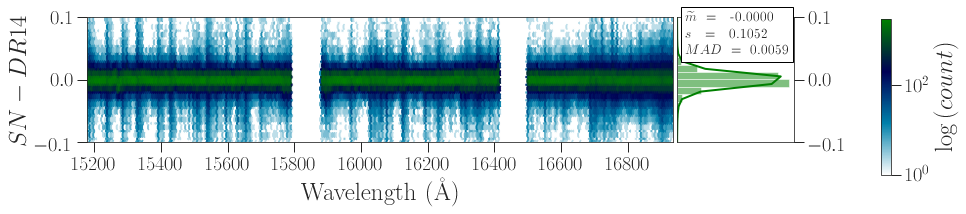

In [11]:
# Load ASPCAP wave-grid
wave_grid = np.load(data_dir+'wave_grid_ASPCAP.npy')
start_w = len(wave_grid)-x_pred.shape[1]
wave_grid = wave_grid[start_w:]

# Plot residual
plot_spec_resid_density(wave_grid, resid, labels=[r'$SN - DR14$'], ylim=(-0.1,0.1), hist=True, kde=True,
                            dist_bins=180, hex_grid=300, bias='med',
                            bias_label='$\widetilde{{m}}$ \ ',
                            cmap="ocean_r", savename=None)

In [12]:
def calc_dxdy(obs_ae, y, x_mean, x_std, dy):

    # Repeat labels into matrix
    y_ref = torch.cat(y.size(1)*[y.clone()])
    # Apply + an - deviations 
    y_pos = y_ref.clone()+dy
    y_neg = y_ref.clone()-dy

    # Produce x_synth using the emulator for + and - 
    x_pos = obs_ae.run_emulator(y_pos)
    x_neg = obs_ae.run_emulator(y_neg)

    # Normalize the spectra
    x_pos = (x_pos - x_mean) / x_std
    x_neg = (x_neg - x_mean) / x_std
    
    # Only select last 7167 pixels
    x_pos = x_pos[:,47:]
    x_neg = x_neg[:,47:]
    
    # Calculate the Jacobian for the emulator
    J_tgt = x_pos - x_neg
    
    # Produce x_synth using the decoder for + and -
    x_pos = obs_ae.yz_to_xsynth(y_pos)
    x_neg = obs_ae.yz_to_xsynth(y_neg)
    
    # Calculate Jacobian for the decoder
    J_dec = x_pos - x_neg
    
    return J_tgt.data.numpy(), J_dec.data.numpy()


# Calculate the matrix that will be applied to our "reference" labels
# to evaluate our gradients throughout training.
dy = torch.Tensor((np.eye(25,25)*np.array([[25., 0.025, 0.05, 
                                            *np.repeat(0.025, 20), 
                                            1.25, 0.5]])).astype(np.float32))

# Define a set of reference stellar labels
ref_labels = np.array([[4750., 2.5, 1.5, 0., 0., 0., 0., 0., 0., 0., 0., 0., 
                        0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 7.5, 6.]])
ref_labels = torch.from_numpy(ref_labels.astype(np.float32)) 

# Calculate the Jacobians
J_tgt, J_dec = calc_dxdy(obs_ae, ref_labels, x_mean, x_std, dy)
# Difference of Jacobians
J_diff = J_dec - J_tgt

[Na/H]


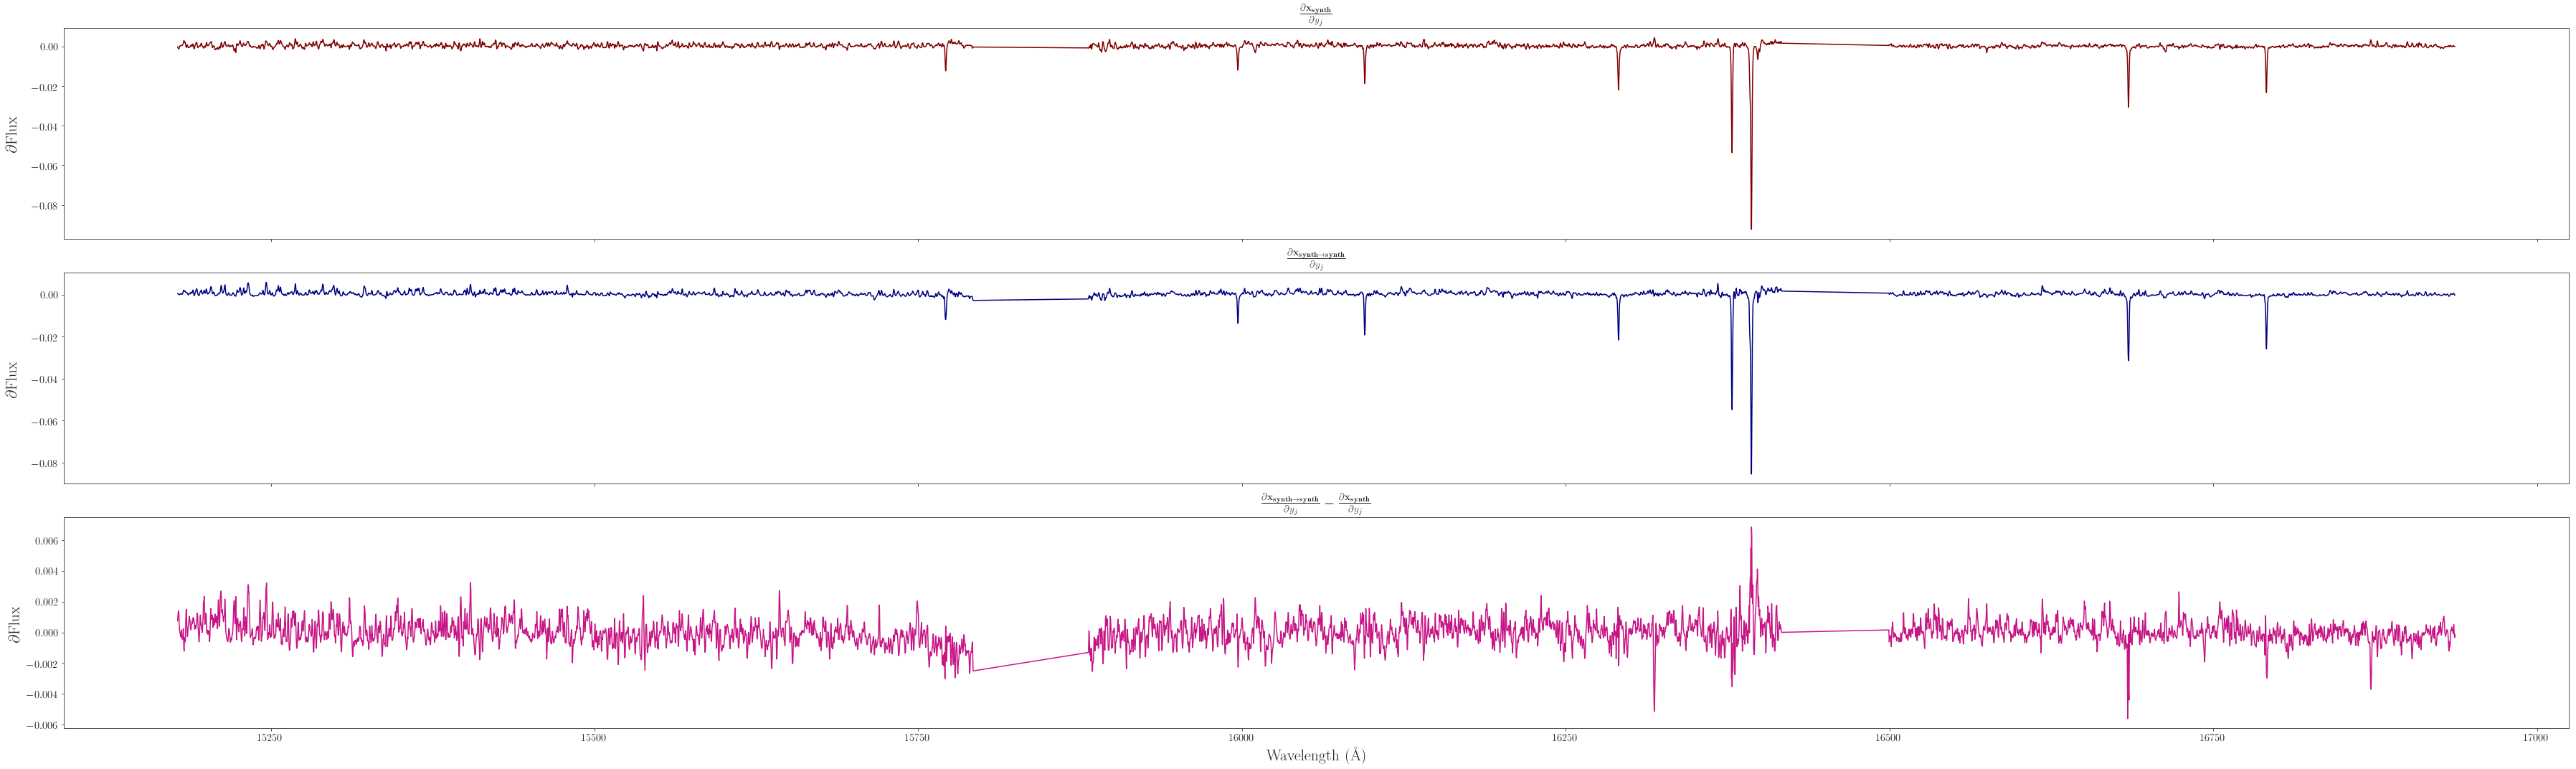

[Mg/H]


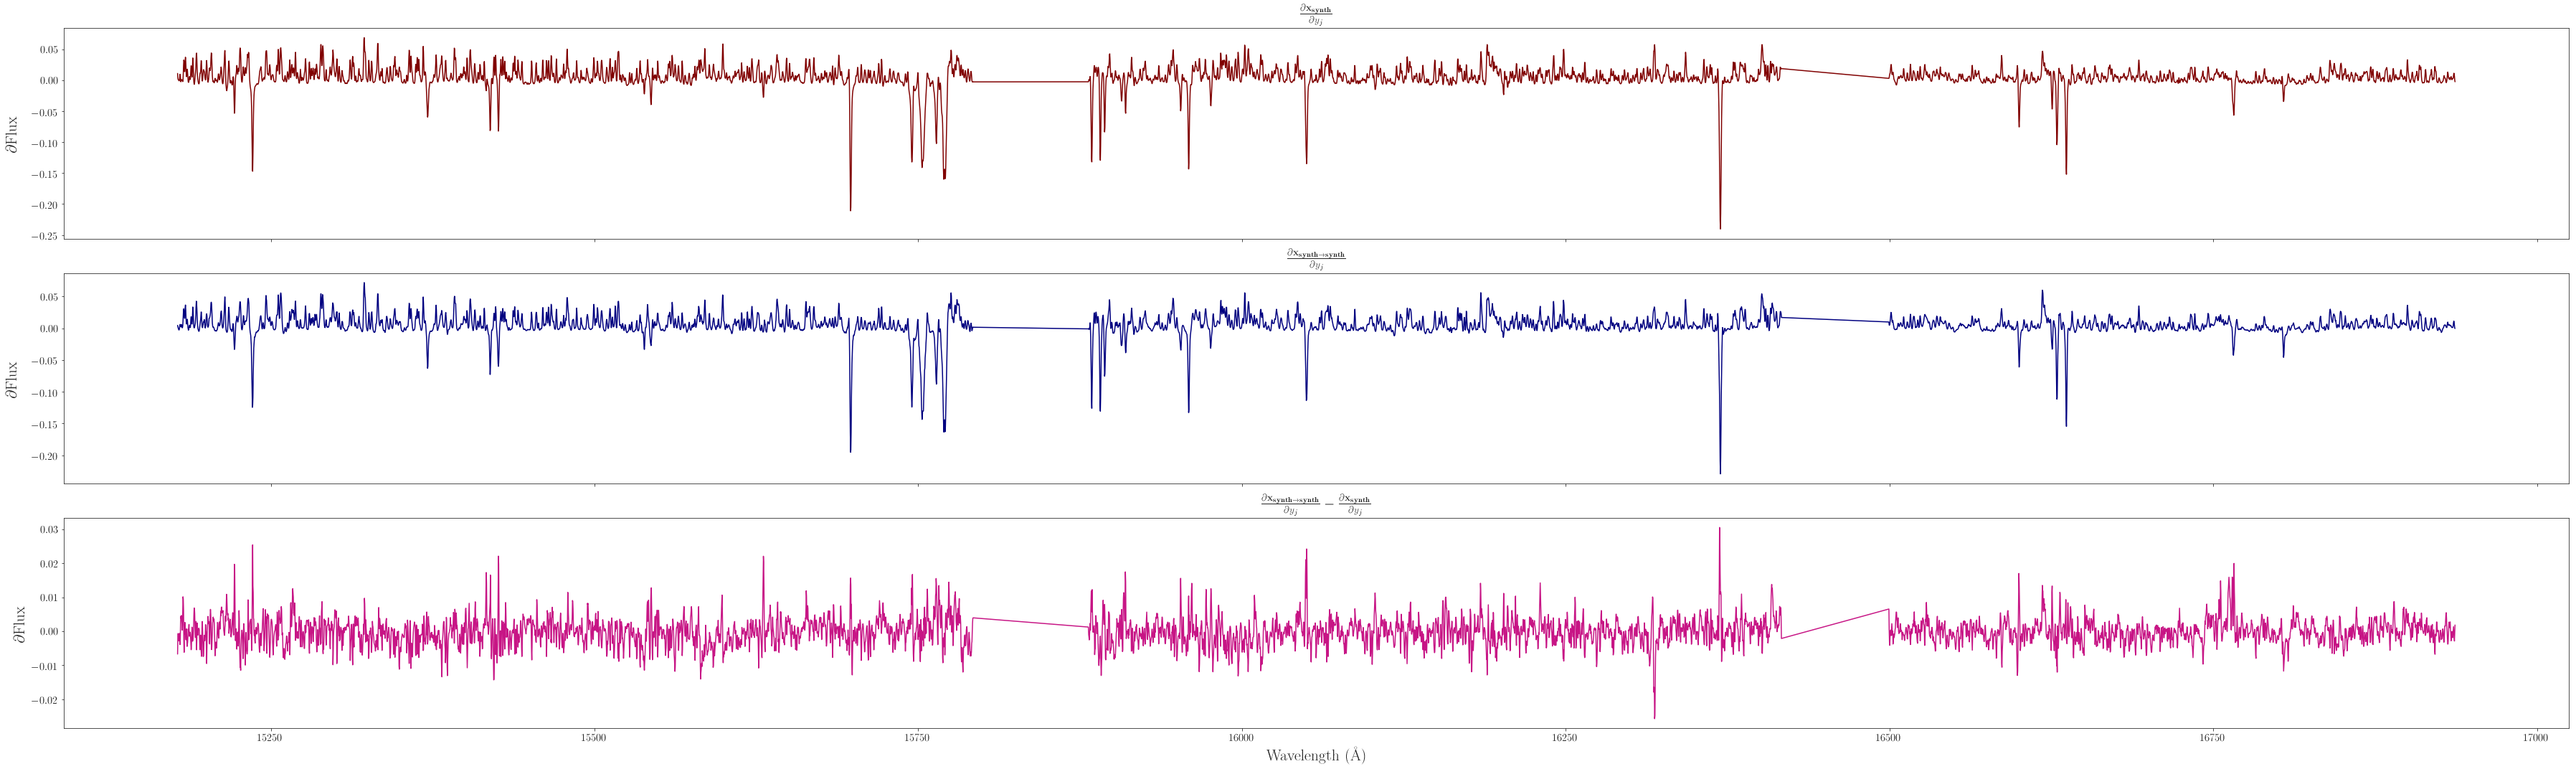

[S/H]


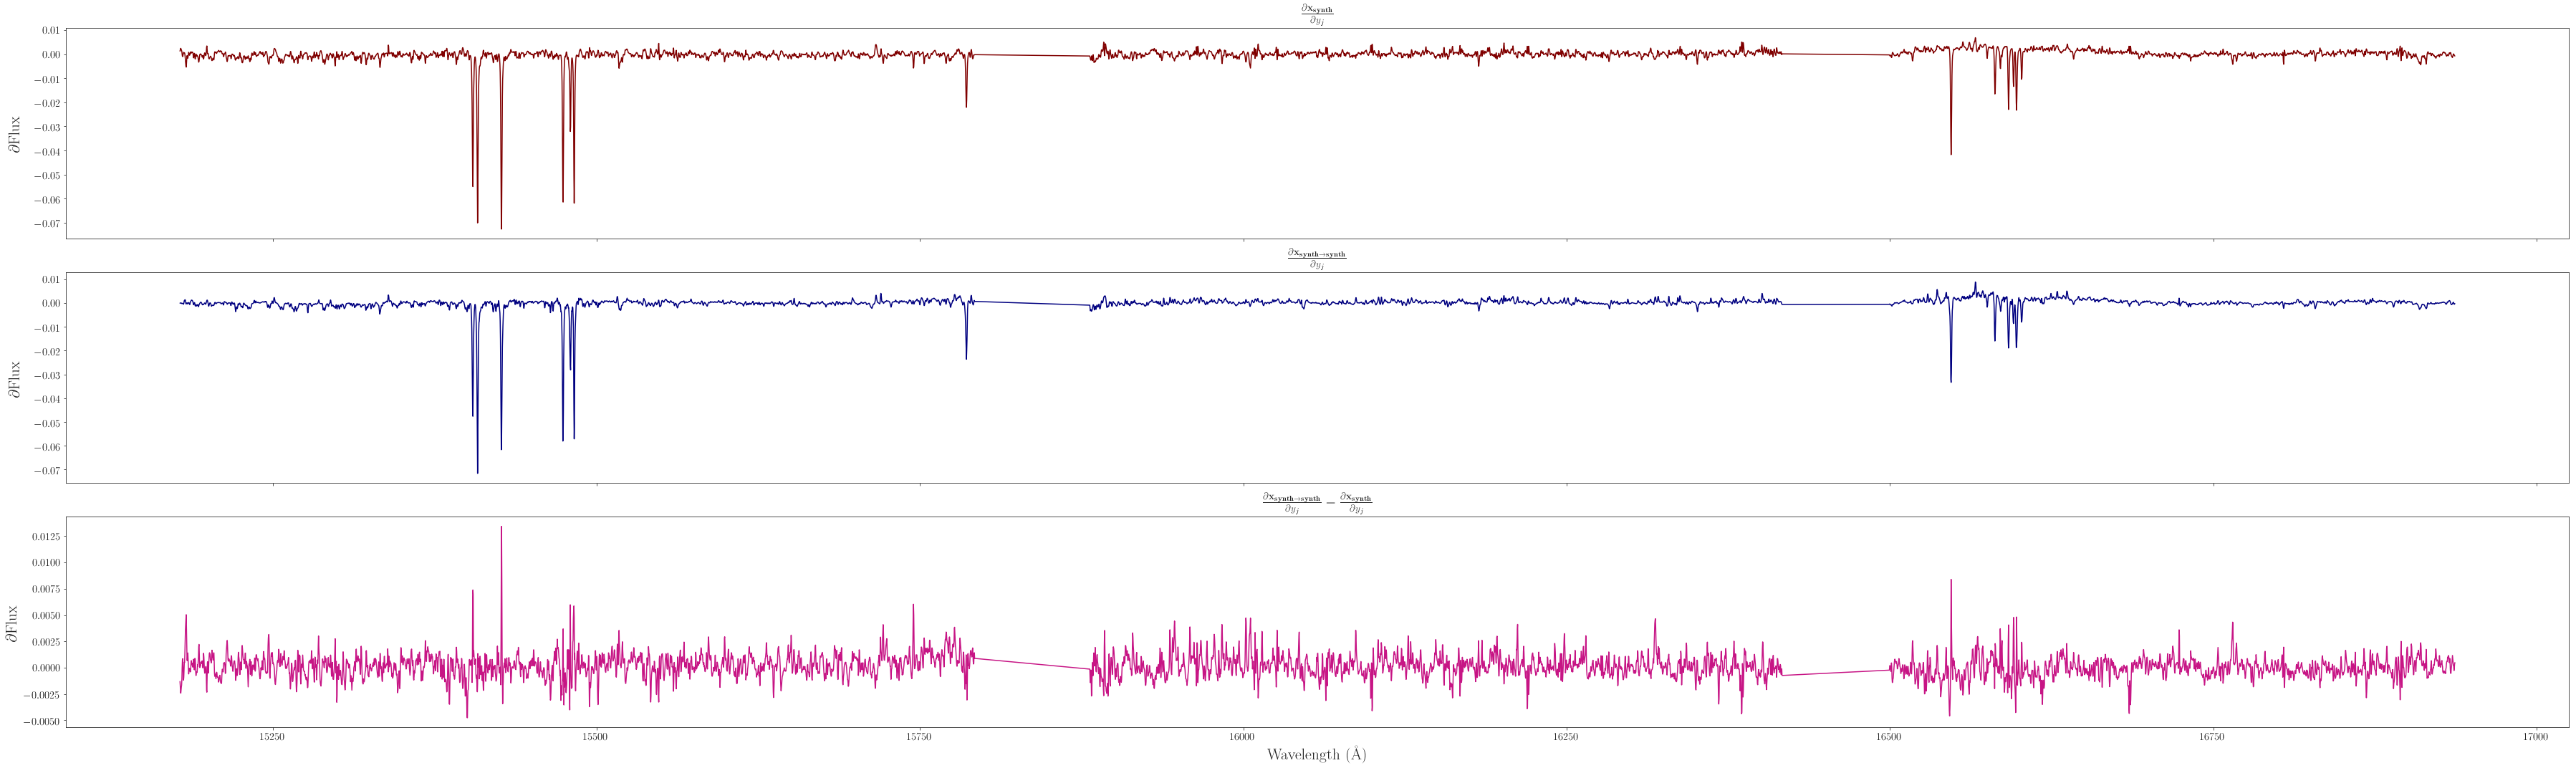

[K/H]


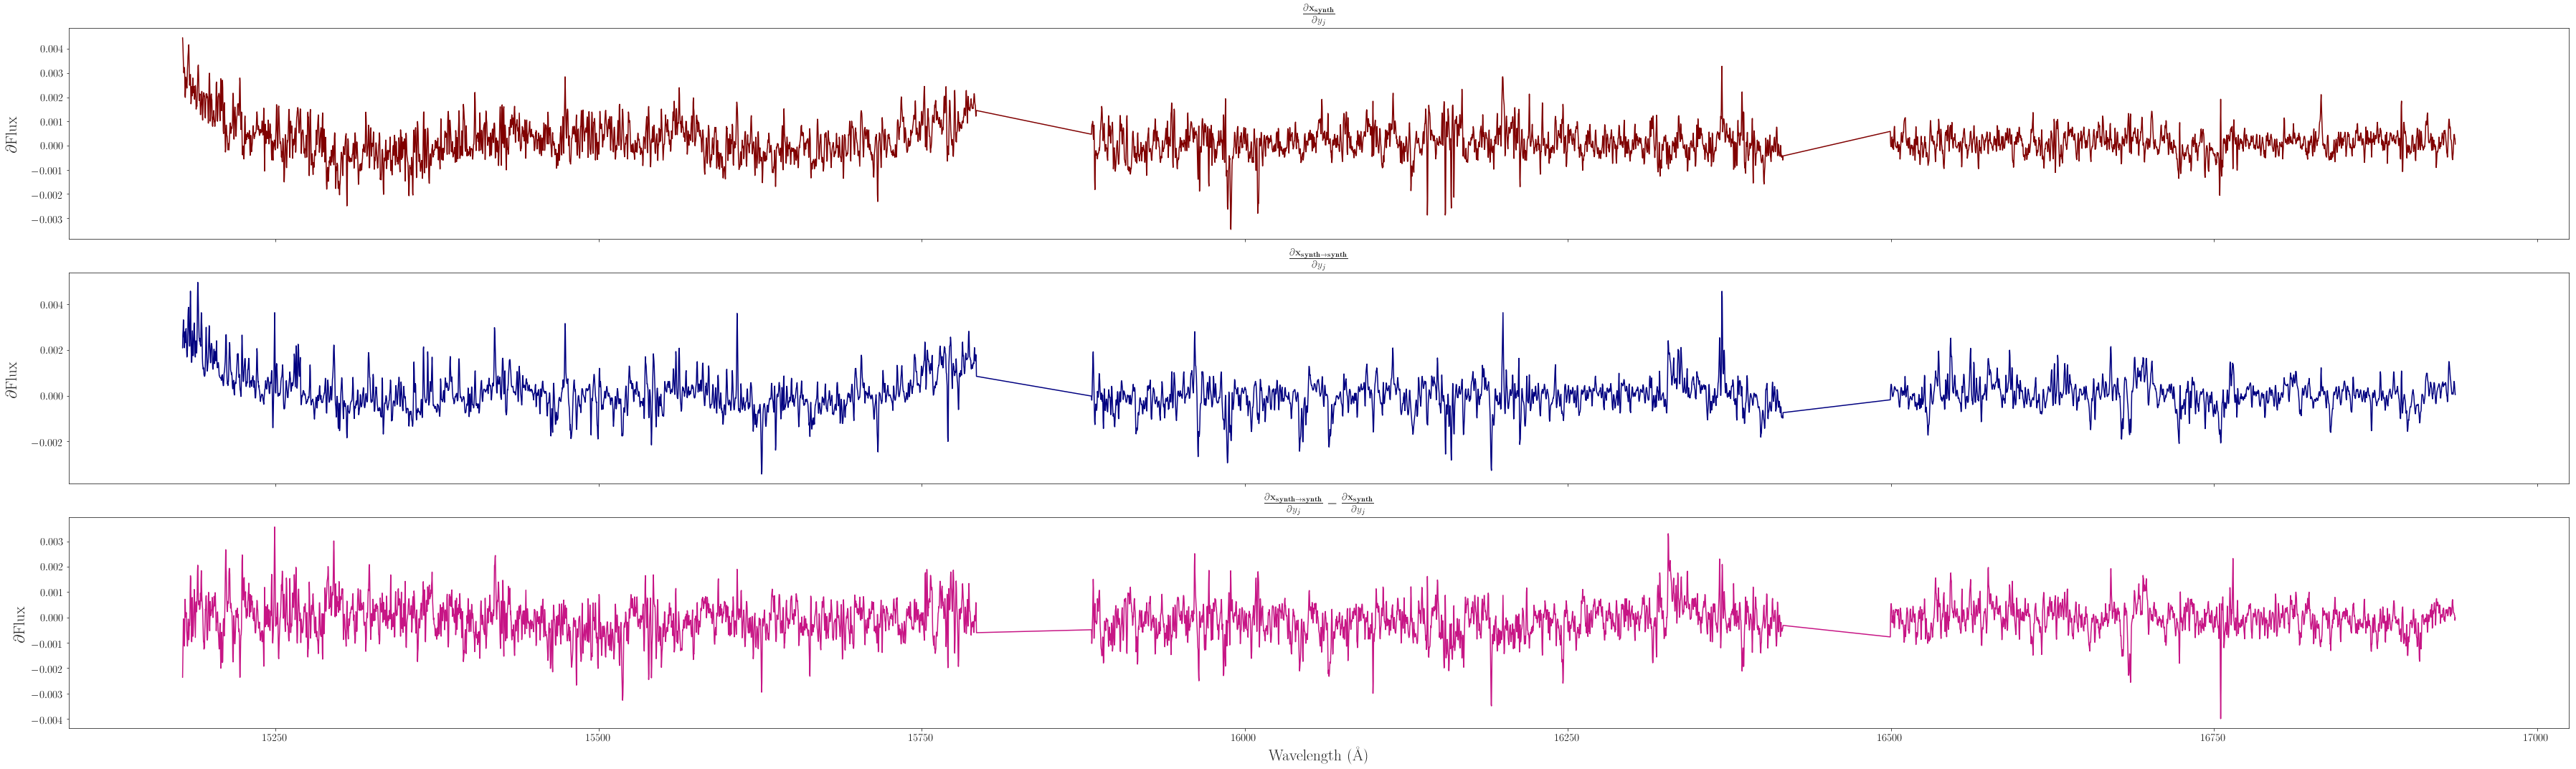

[Cu/H]


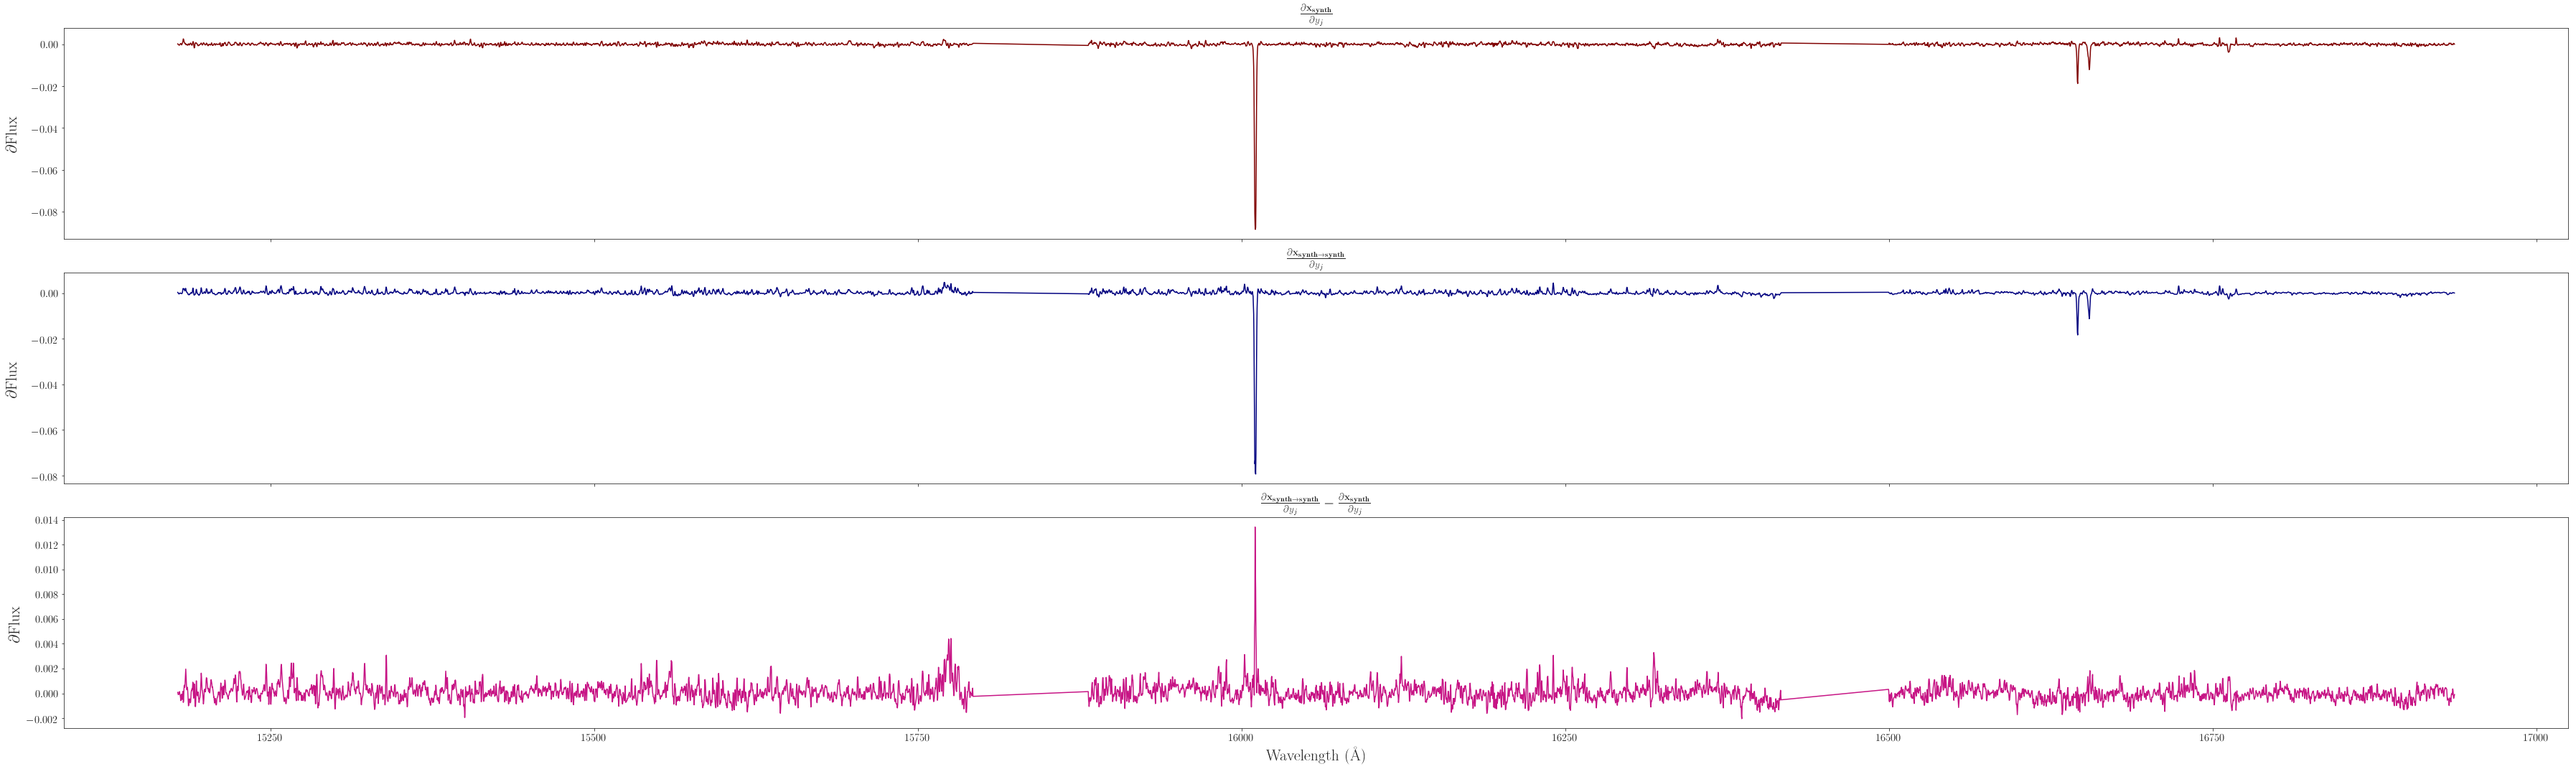

In [13]:
plot_J_diff(wave_grid, J_tgt, J_dec, J_diff, ele_indices=[6,7,11,12,21])